In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weighted,
    train_weighted,
    EarlyStopper,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [3]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df["count_scaled"] = df["count"].apply(lambda x: 1 + np.log10(x))

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(drop=True)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [4]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
16,2007,2.204983e+06,0.227171,2.619291
76,2008,2.197454e+06,0.139858,1.066988
782,2009,2.069647e+06,-0.061378,-0.060949
2135,2010,1.825045e+06,-0.169473,-0.456003
3262,2011,1.620211e+06,-0.217156,-0.780465
4190,2012,1.684720e+06,-0.076888,-0.332538
5228,2013,1.947510e+06,0.202010,1.113350
7397,2014,2.130575e+06,0.264646,1.446387
8877,2015,2.257352e+06,0.159097,0.843063
9755,2016,2.645833e+06,0.241840,1.197871


In [5]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
41,2020,3.849920e+06,0.257623,1.115681
1789,2021,4.164547e+06,0.225359,0.829393
2984,2022,4.462737e+06,0.159177,0.495757


In [6]:
idx = 3793
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window

Target: 0.7682286537439242


,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed,unit_price_median,year,years_since_crisis,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,total_tax,total_tax_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,area_code,area,new_dwellings_ratio_normalized_yearly,log_new_dwellings_ratio,log_new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,count_normalized_yearly,total_traded_area_normalized_yearly,population_normalized_yearly,taxpayer_count_normalized_yearly,taxable_income_normalized_yearly,taxable_income_per_taxpayer_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,new_dwellings_normalized_yearly,existing_dwellings_normalized_yearly,net_migration_ratio_normalized_yearly,total_tax_normalized_yearly,total_tax_growth_normalized_yearly,count_scaled
10128,-0.228076,29425.192034,22068.965517,2016,8,15.0,4655.0,39045.0,17039.0,45695721.0,2681.831152,0.006674,-0.000121,4601293.0,0.010837,184.0,17589.0,-0.002715,0.010461,1,1,1,1,33207,Okayama-ken Ibara-shi,0.270168,0.004520,0.275540,-0.347090,-1.254080,-0.329048,-0.389215,-0.246364,-0.247733,-0.251165,-0.333145,-0.562732,-0.385485,-0.240589,-0.211950,0.039762,-0.233665,-0.066134,2.176091
11716,-0.288479,24739.513102,23435.504470,2017,9,8.0,3010.0,38939.0,17086.0,46078256.0,2696.842795,0.008371,0.005598,4666822.0,0.014241,97.0,17773.0,-0.001823,0.005458,1,1,1,1,33207,Okayama-ken Ibara-shi,-0.270967,0.002364,-0.268153,-0.361081,-1.567888,-0.366535,-0.439306,-0.246393,-0.249048,-0.252337,-0.339803,-0.225721,-0.062499,-0.274879,-0.212563,0.196823,-0.233037,-0.017353,1.903090
11984,-0.191715,23783.940766,22580.645161,2018,10,13.0,4705.0,38868.0,17064.0,49888480.0,2923.609939,0.082690,0.084086,4753681.0,0.018612,171.0,17870.0,-0.003911,0.009569,1,1,1,1,33207,Okayama-ken Ibara-shi,0.236781,0.004136,0.241492,-0.360712,-1.025484,-0.344355,-0.399073,-0.246283,-0.250317,-0.244376,-0.011902,1.303220,1.646058,-0.227489,-0.213884,-0.134851,-0.221467,0.269102,2.113943
13764,-0.079035,22784.213751,28339.160839,2019,0,16.0,6635.0,38716.0,17047.0,47718139.0,2799.210360,-0.043504,-0.042550,4682972.0,-0.014875,161.0,18031.0,-0.008575,0.008929,1,1,1,1,33207,Okayama-ken Ibara-shi,0.267070,0.003861,0.271095,-0.356525,-0.455402,-0.321974,-0.343900,-0.246433,-0.251343,-0.251313,-0.238765,-1.443724,-1.497869,-0.237085,-0.214356,-0.825890,-0.221898,-0.781798,2.204120
14923,0.114358,26503.829565,17241.379310,2020,1,7.0,2615.0,38384.0,16973.0,47516672.0,2799.544689,-0.004222,0.000119,4600312.0,-0.017651,139.0,18170.0,-0.005471,0.007650,1,1,1,1,33207,Okayama-ken Ibara-shi,0.226087,0.003310,0.229470,-0.324986,0.444018,-0.374663,-0.464129,-0.247304,-0.252305,-0.252535,-0.252576,-0.275272,-0.079340,-0.240426,-0.214809,-0.444011,-0.223547,-0.259973,1.845098


In [7]:
log_normalize_columns = []

normalize_columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
]

maintain_columns = [
    metric_pct_chg,
    # "years_since_crisis",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

id_columns = [
    "area_code",
    "area",
    "year",
]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [8]:
feature_columns

['unit_price_median_smoothed_normalized_yearly',
 'unit_price_median_smoothed_pct_chg_normalized_yearly',
 'count_normalized_yearly',
 'total_traded_area_normalized_yearly',
 'population_normalized_yearly',
 'taxpayer_count_normalized_yearly',
 'taxable_income_normalized_yearly',
 'taxable_income_per_taxpayer_normalized_yearly',
 'taxable_income_growth_normalized_yearly',
 'taxable_income_per_taxpayer_growth_normalized_yearly',
 'new_dwellings_normalized_yearly',
 'existing_dwellings_normalized_yearly',
 'new_dwellings_ratio_normalized_yearly',
 'net_migration_ratio_normalized_yearly',
 'total_tax_normalized_yearly',
 'total_tax_growth_normalized_yearly',
 'unit_price_median_smoothed_pct_chg',
 'years_since_crisis',
 'migrations_is_available',
 'taxable_income_is_available',
 'dwellings_is_available',
 'total_tax_is_available']

In [9]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 22) (1,) [-0.02971171] [2.96848295]
1 (0, 22) (1,) [-1.03503937] [1.60205999]
2 (0, 22) (1,) [0.79184607] [4.02978947]
3 (0, 22) (1,) [-1.46725164] [1.90308999]
0 torch.Size([5, 22]) torch.Size([1]) tensor([-0.0297]) tensor([2.9685])
1 torch.Size([5, 22]) torch.Size([1]) tensor([-1.0350]) tensor([1.6021])
2 torch.Size([5, 22]) torch.Size([1]) tensor([0.7918]) tensor([4.0298])
3 torch.Size([5, 22]) torch.Size([1]) tensor([-1.4673]) tensor([1.9031])


In [10]:
BATCH_SIZE = 256

In [11]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18826 entries, 0 to 18825
Data columns (total 44 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   unit_price_median_smoothed_pct_chg                    18826 non-null  float64
 1   unit_price_median_smoothed                            18826 non-null  float64
 2   unit_price_median                                     18826 non-null  float64
 3   year                                                  18826 non-null  int64  
 4   years_since_crisis                                    18826 non-null  int64  
 5   count                                                 18826 non-null  float64
 6   total_traded_area                                     18826 non-null  float64
 7   population                                            18826 non-null  float64
 8   taxpayer_count                                        18

# Building the Transformer Model

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [14]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [15]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 22]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2156870365142822


In [16]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 30

In [17]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [18]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 8.5442, Eval Loss: 9.0054
Train R^2: -0.0035, Eval R^2: -0.0464
Epoch: 1
Train Loss: 6.5647, Eval Loss: 11.5542
Train R^2: 0.2327, Eval R^2: -0.3404


KeyboardInterrupt: 

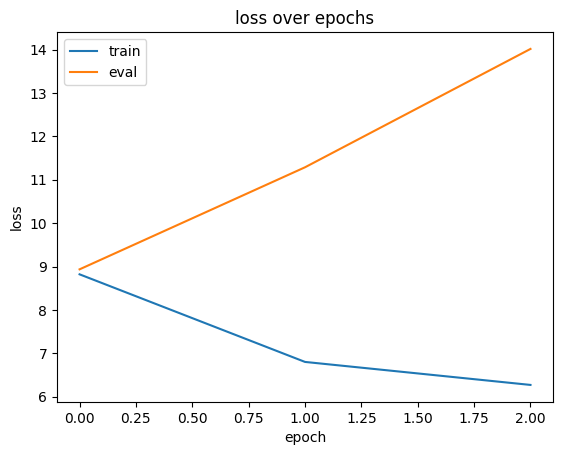

In [62]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

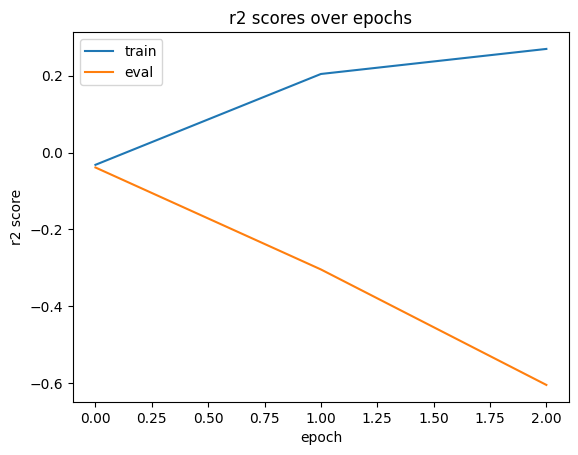

In [63]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()